In [314]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl

ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')
s = ctrl.tf('s')

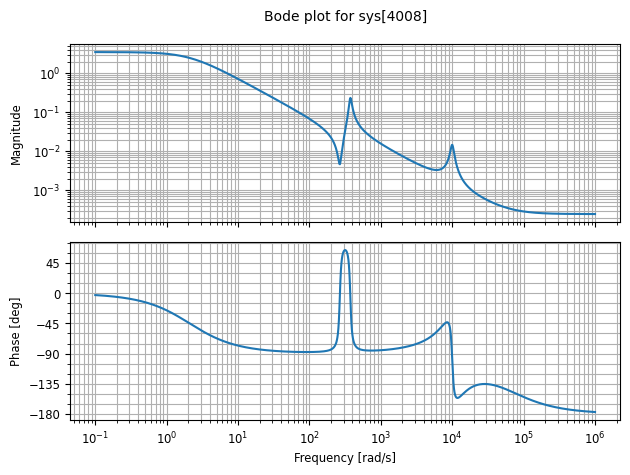

In [315]:
def pt2(omega,zeta):
    return ctrl.tf(omega**2,[1,2*zeta*omega,omega**2])

def notch(omega_n,zeta_n,omega_d,zeta_d):
    return pt2(omega_d,zeta_d)/pt2(omega_n,zeta_n)

def tf_from_txt(fname):
    with open(fname) as f:
        lines = f.readlines()
    
    lines_s = ''.join(lines)

    num_s = lines_s.split(']')[0].strip()
    den_s = lines_s.split(']')[1].strip()

    num_s = num_s.replace('[','').replace(']','').replace('\n','')
    den_s = den_s.replace('[','').replace(']','').replace('\n','')

    num = [float(x) for x in num_s.split()]
    den = [float(x) for x in den_s.split()]
    return ctrl.tf(num,den)


Gf = tf_from_txt(r'tf_txt\Gf.txt')

ctrl.bode(Gf)


In [316]:
Gf

TransferFunction(array([-2.45755575e-04,  1.20077395e+01,  1.20380740e+05,  1.45058965e+09,
        4.06012480e+10,  1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

# Model error (Model uncertainty)

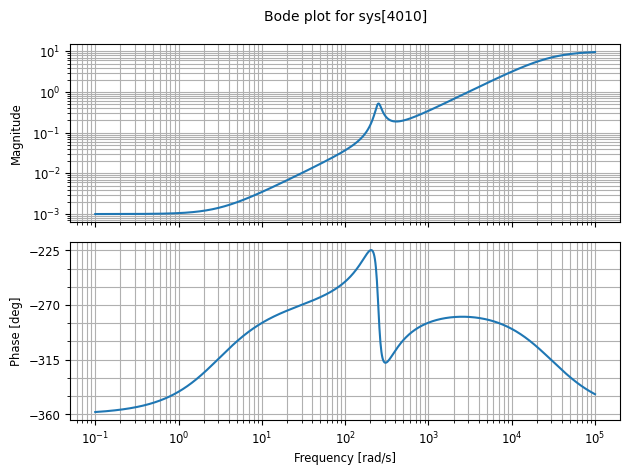

In [317]:
W_delta = tf_from_txt(r'tf_txt\W_delta.txt')

ctrl.bode(W_delta)

# Controller from AST

SpeedCtrl(Kp=22.242147839669272, Ti=0.035, Ts=0.00025, ref_mdl_active=True, ref_mdl_freq=37.567485311159444, ref_mdl_d=0.7071, ref_mdl_delay=0.0, act_value_filters=[], current_setp_filters=[PT2(freq=2000.0, damping=0.7071), SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)])
PT2(freq=2000.0, damping=0.7071)
SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)


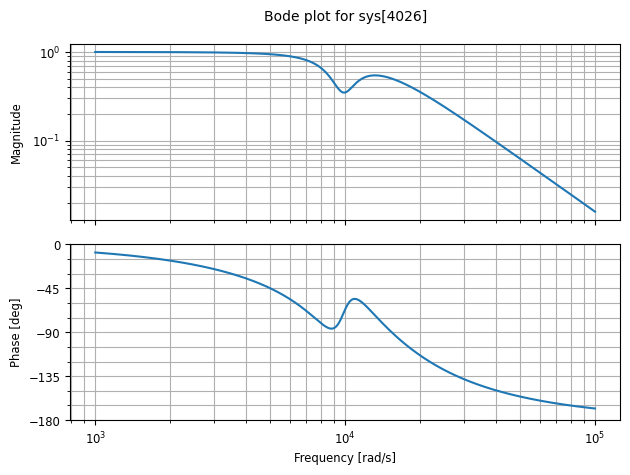

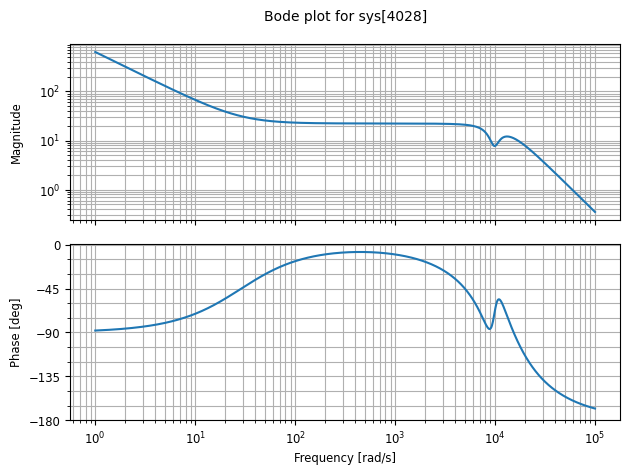

In [318]:
print(ast.speed_ctrl_params)

speed_ctrl = ast.speed_ctrl_params

C = speed_ctrl.Kp*(1 + 1/(s*speed_ctrl.Ti))

assert len(speed_ctrl.act_value_filters) == 0

F = 1 

for filt in speed_ctrl.current_setp_filters:
    print(filt)
    if isinstance(filt,tt.tracetypes.PT2):
        pt2i = tt.sinu_tf.PT2(filt.freq,filt.damping)
        F *= pt2i
    elif isinstance(filt,tt.tracetypes.SecondOrdFilter):
        pt2i = tt.sinu_tf.PT2(filt.den_f,filt.den_d) / tt.sinu_tf.PT2(filt.num_f,filt.num_d)
        F *= pt2i
    else:
        raise Exception('Only PT2 filter supported for now..')
    



ctrl.bode(F)
plt.figure()
ctrl.bode(F*C)



0 states have been removed from the model
10 states have been removed from the model


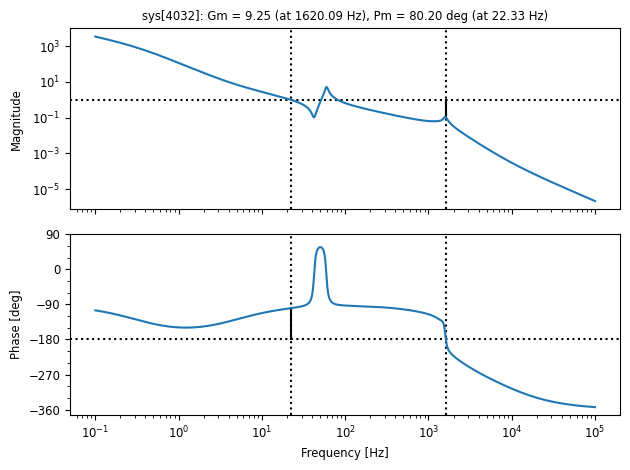

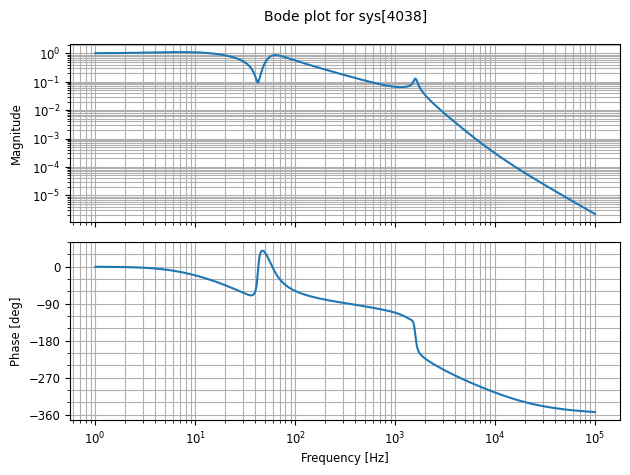

In [319]:

L = C*F*Gf
L = ctrl.minreal(L)

ctrl.bode(L,display_margins=True,Hz=True)   

plt.figure()

CL = L/(1+L)
CL = ctrl.minreal(CL)

ctrl.bode(CL,Hz=True)

# Import Hinf controller

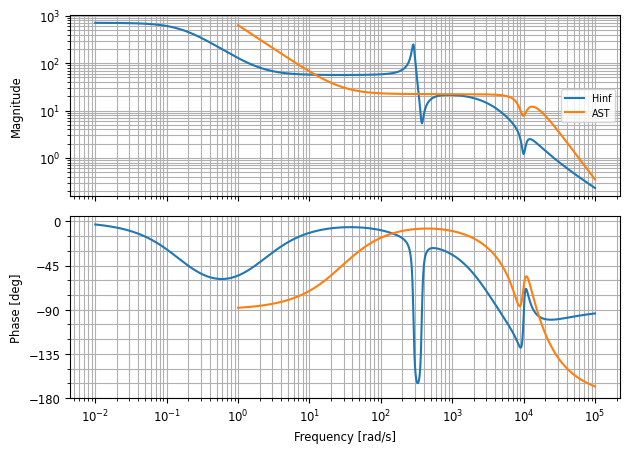

In [320]:


lines = []
with open(r'tf_txt/K_hinf.txt','r') as f:
    lines = f.readlines()
lines

lines = [x.strip().replace('[','').replace(']','') for x in lines]
    

num = [float(x) for x in lines[0].split(',')]
den = [float(x) for x in lines[1].split(',')]

num = np.array(num)
den = np.array(den)

num =  np.flip(num)
den = np.flip(den)

C_hinf = ctrl.tf(num,den)
C_hinf.name = 'Hinf'
C_ast = C*F 
C_ast.name = 'AST'

ctrl.bode(C_hinf)
ctrl.bode(C_ast)

# IMC Controller

In [321]:
def plot_mag(G):
    resp = ctrl.frequency_response(G)
    w = resp.omega 
    Y = resp.response[0][0]

    plt.semilogx(w,ctrl.mag2db(np.abs(Y)))


<TransferFunction>: sys[4047]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s - 5.888e+04
-------------
      1

No unstable zeros  1
Rel degree: 0
2
0 states have been removed from the model
Reference model (Desired closed loop dynamics)


TransferFunction(array([-3.28524954e+00,  1.93444246e+05]), array([1.00000000e+00, 8.79645943e+02, 1.93444246e+05]))

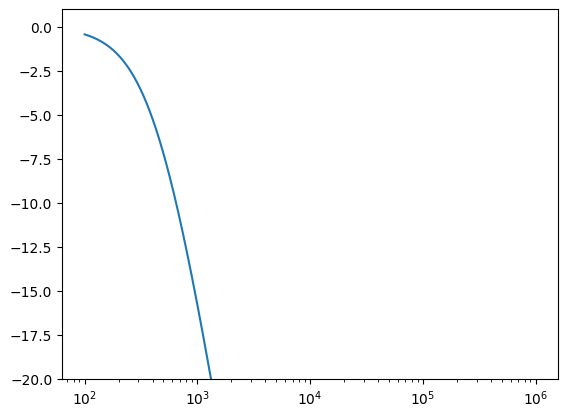

In [322]:


def imc_invert(G):
    # Only invers stable zeros
    zeros = ctrl.zeros(G)

    new_num = ctrl.tf(G.den[0][0],1) # all poles as zeros
    new_den = 1.0

    for z in zeros:

        # Singe or complez pole?
        p = 1.0
        if np.abs(np.imag(z)) < 1e-6:
            # real pole     
            p = (s-z)
        else:

            w0 = np.imag(z)
            zeta = -np.real(z)/w0

            p = (s**2 + 2*zeta*w0*s + w0**2)/w0**2

        if np.real(z) < 0:
            # stable
            new_den *= p
        else:
            new_num *= p

    G_inv = new_num/new_den
    G_inv = ctrl.minreal(G_inv)

    new_dc_gain = 1/G.dcgain()
    scale = new_dc_gain/G_inv.dcgain()

    G_inv *= scale
    
    return G_inv

def unstable_zeros(G):
    # Only invers stable zeros
    zeros = ctrl.zeros(G)

    new_zeros = 1.0

    for z in zeros:

        # Singe or complez pole?
        p = 1.0
        if np.abs(np.imag(z)) < 1e-6:
            # real pole     
            z = np.real(z)
            p = (s-z)
        else:

            w0 = np.imag(z)
            zeta = -np.real(z)/w0

            p = (s**2 + 2*zeta*w0*s + w0**2)/w0**2

        if np.real(z) < 0:
            # stable
            #new_den *= p
            pass
        else:
            new_zeros *= p

    
    return new_zeros


unstabl_zers = unstable_zeros(Gf)
print(unstabl_zers)

Ns = len(unstabl_zers.zeros())
print('No unstable zeros ',Ns)

No = len(Gf.poles()) - len(Gf.zeros())
print('Rel degree:',No)

filt_order = No + Ns +1
print(filt_order)

# Ref model
w_cl_m = 70*2*np.pi
M = unstabl_zers / (s/w_cl_m + 1)**filt_order
M = ctrl.minreal(M)
M *= 1/M.dcgain()

plot_mag(M)
plt.ylim([-20,1])
print("Reference model (Desired closed loop dynamics)")
M


In [323]:
def increase_damping(C,min_dampng):

    new_pole_poly = 1.0

    eps = 1e-6

    for z in C.poles():

        # Singe or complez pole?
        p = 1.0
        if np.abs(np.imag(z)) < eps:
            # real pole     
            
            z = np.real(z)
            if np.abs(z) > eps:
                p = (s-z)/(-z)
            else:
                p = (s-z)
        elif np.imag(z) > eps:

            w0 = np.imag(z)
            zeta = -np.real(z)/w0

            zeta = max(zeta,min_dampng)

            p = (s**2 + 2*zeta*w0*s + w0**2)/w0**2

        new_pole_poly *= p

    zero_poly = ctrl.tf(C.num[0][0],1)
    C_new = zero_poly/new_pole_poly


    gain0 = ctrl.frequency_response(C).response[0][0]
    gain0 = np.mean(np.abs(gain0))

    gain1 = ctrl.frequency_response(C_new).response[0][0]
    gain1 = np.mean(np.abs(gain1))

    C_new *= gain0/gain1


    return C_new


    



3 states have been removed from the model


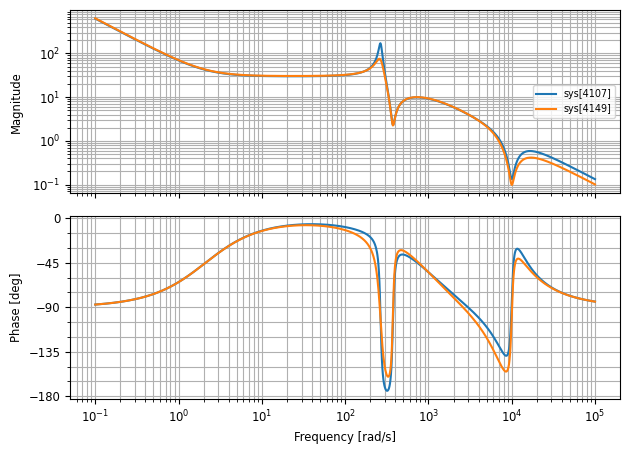

In [324]:
C_imc = M/(1-M) * (1/Gf)
C_imc = ctrl.minreal(C_imc)

ctrl.bode(C_imc)

C_imc = increase_damping(C_imc,0.1)#*1e-14

ctrl.bode(C_imc)


5 states have been removed from the model
6 states have been removed from the model


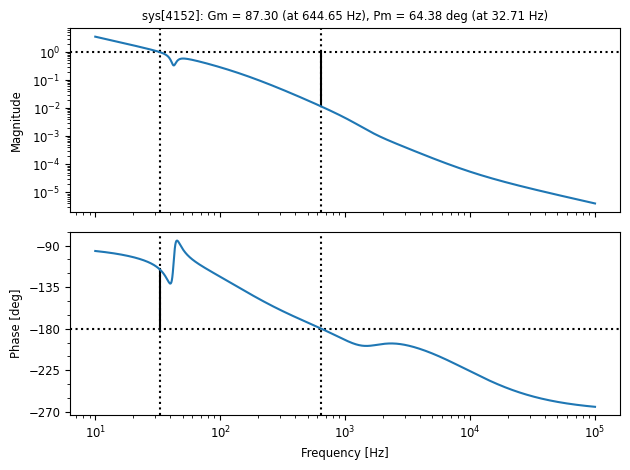

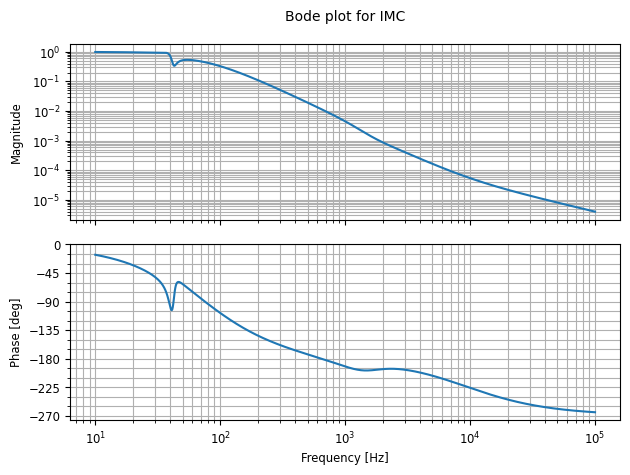

In [325]:
L_imc = C_imc*Gf
L_imc = ctrl.minreal(L_imc)

ctrl.bode(L_imc,display_margins=True,Hz=True)

CL_imc = L_imc/(1+L_imc)
CL_imc = ctrl.minreal(CL_imc)

CL_imc.name = 'IMC'

plt.figure()
ctrl.bode(CL_imc,Hz=True)


5 states have been removed from the model
9 states have been removed from the model


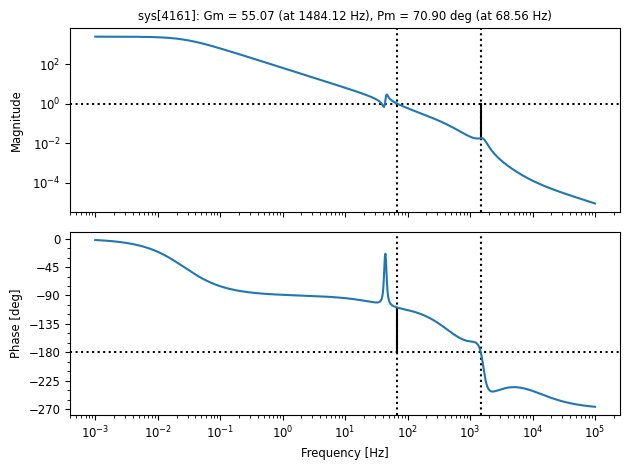

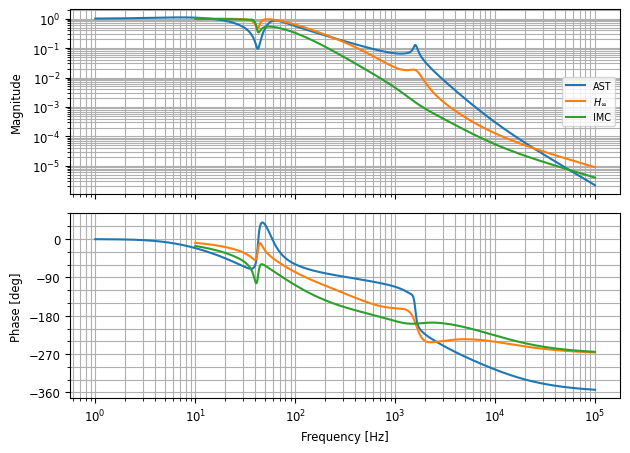

In [326]:
Lh = C_hinf*Gf
Lh = ctrl.minreal(Lh)

ctrl.bode(Lh,display_margins=True,Hz=True)   



CLh = Lh/(1+Lh)
CLh = ctrl.minreal(CLh)


CL.name = r'AST'
CLh.name = r'$H_\infty$'

plt.figure()
ctrl.bode(CL,Hz=True)
ctrl.bode(CLh,Hz=True)
ctrl.bode(CL_imc,Hz=True)

(10, 2000)

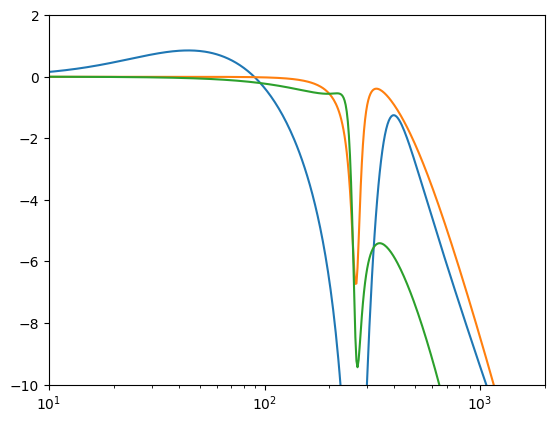

In [327]:

plot_mag(CL)
plot_mag(CLh)
plot_mag(CL_imc)

plt.ylim([-10,2])
plt.xlim([10,2000])


0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model


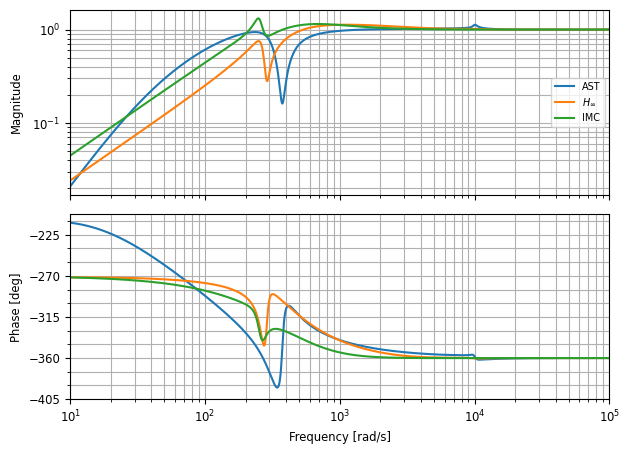

In [328]:

S_ast = 1/(1+L)
S_hinf = 1/(1+Lh)
S_imc = 1/(1+L_imc)

S_ast = ctrl.minreal(S_ast)
S_hinf = ctrl.minreal(S_hinf)
S_imc = ctrl.minreal(S_imc)

S_ast.name = r'AST'
S_hinf.name = r'$H_\infty$'
S_imc.name = 'IMC'

omega_lim = [10,1e5]

ctrl.bode(S_ast,omega_limits=omega_lim)
ctrl.bode(S_hinf,omega_limits=omega_lim)
ctrl.bode(S_imc,omega_limits=omega_lim)

1 states have been removed from the model
9 states have been removed from the model
6 states have been removed from the model


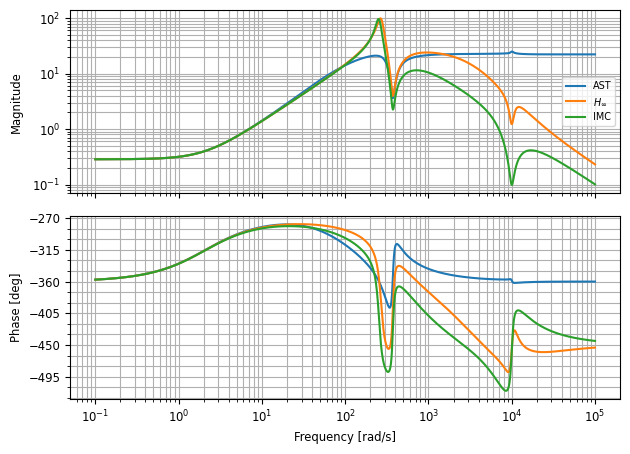

In [329]:
SC_ast = 1/(1+L)*C
SC_hinf = 1/(1+Lh)*C_hinf
SC_imc = 1/(1+L_imc)*C_imc

SC_ast = ctrl.minreal(SC_ast)
SC_hinf = ctrl.minreal(SC_hinf)
SC_imc = ctrl.minreal(SC_imc)


SC_ast.name = r'AST'
SC_hinf.name = r'$H_\infty$'
SC_imc.name = 'IMC'

ctrl.bode(SC_ast)
ctrl.bode(SC_hinf)
ctrl.bode(SC_imc)

0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model


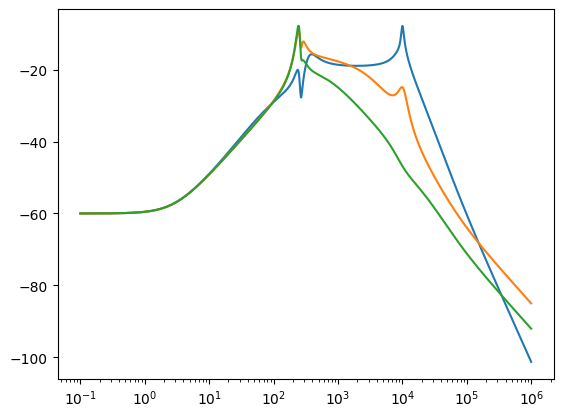

In [330]:
T_rob = CL *  W_delta
T_rob = ctrl.minreal(T_rob)
T_rob.name = r'AST' 

T_hinf = CLh *  W_delta
T_hinf = ctrl.minreal(T_hinf)
T_hinf.name = r'$H_\infty$'

T_imc = CL_imc *  W_delta
T_imc = ctrl.minreal(T_imc)
T_imc.name = 'IMC'


plot_mag(T_rob)  
plot_mag(T_hinf)
plot_mag(T_imc)



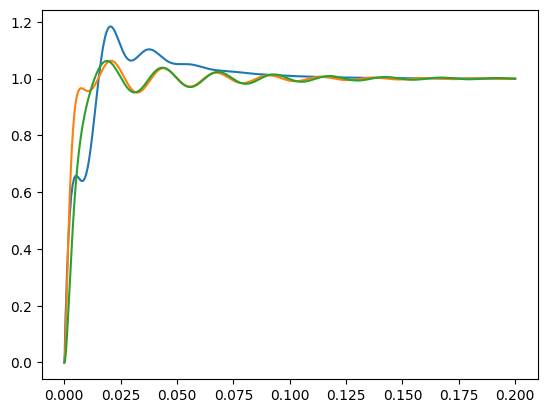

In [331]:


t = np.linspace(0,0.2,1000)

t0,y0 = ctrl.step_response(CL,T=t)
t1,y1 = ctrl.step_response(CLh,T=t)
t2,y2 = ctrl.step_response(CL_imc,T=t)

plt.figure()
plt.plot(t0,y0)
plt.plot(t1,y1)
plt.plot(t2,y2)

